In [2]:
import numpy as np
import pandas as pd
import Funciones_sismos as BN
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [3]:
E = 1900000   #T/m^2
gdl = 4
col = 0.3   #m
num_col = 9
h = 3 #m
inercia_efectiva = 1
I = np.ones(gdl)*((col**4)/12)*inercia_efectiva #m**4
H = np.ones(gdl)*h #m
g = 9.8  #m/(s**2)
m_piso = 111/g #Tons
m = np.ones(gdl)*m_piso    #T*(s**2)*(m**-1)
r = np.ones(gdl)
coef_castigo = 1
tipo = 1
vector = 0

zona = 5
suelo = 'C'
fip = 1
fie = 1
fa = 1.2
fd = 1.11
fs = 1.11
n = 2.48
z = 0.4     #Para un TR475 años
Imp = 1   #Importancia
rr = 1
R = 6

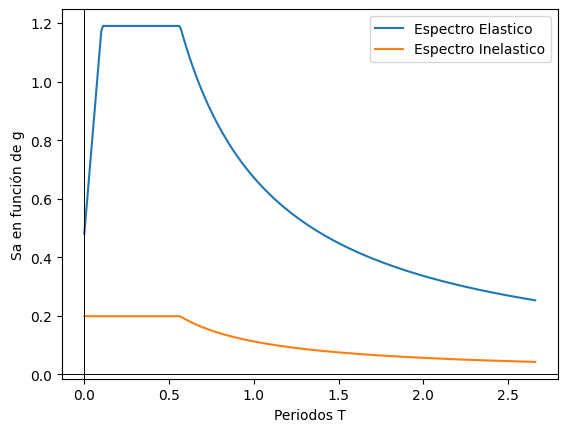

In [4]:
Spec, SpecI, Tmp = BN.Spec_NEC(n, z, fa, fd, fs, rr, Imp, R, fip, fie)

fig, ax = plt.subplots()
plt.plot(Tmp, Spec, label='Espectro Elastico')
plt.plot(Tmp, SpecI, label='Espectro Inelastico')
ax.axhline(0, color='black', linewidth=0.7)
ax.axvline(0, color='black', linewidth=0.7)
ax.set_xlabel('Periodos T')
ax.set_ylabel('Sa en función de g')
plt.legend()
plt.show()

In [5]:
tbl_SpecI = pd.DataFrame(SpecI, columns=['Sa_Espectro_Inelastico'])
display(tbl_SpecI)

,Sa_Espectro_Inelastico
0,0.198400
1,0.198400
2,0.198400
3,0.198400
4,0.198400
...,...
262,0.042763
263,0.042600
264,0.042439
265,0.042279


In [6]:
#Matrices de Masa y Rigidez

K, M = BN.K_M(num_col, H, E, tipo, I, vector, m, coef_castigo)
K_tbl = pd.DataFrame(K)
display(K_tbl.style.set_caption('Matriz de rigidez'))

,0,1,2,3
0,10260.000000,-5130.000000,0.000000,0.000000
1,-5130.000000,10260.000000,-5130.000000,0.000000
2,0.000000,-5130.000000,10260.000000,-5130.000000
3,0.000000,0.000000,-5130.000000,5130.000000


In [7]:
M_tbl = pd.DataFrame(M)
display(M_tbl.style.set_caption('Matriz de masas (Tons)'))

,0,1,2,3
0,11.326531,0.000000,0.000000,0.000000
1,0.000000,11.326531,0.000000,0.000000
2,0.000000,0.000000,11.326531,0.000000
3,0.000000,0.000000,0.000000,11.326531


In [8]:
#EIGENVECTORES Y EIGENVALORES

V, D = eigh(K, M)
w = np.sqrt(V)
T = 2*np.pi/w

df_wTD = pd.DataFrame({'w': w, 'T': T, 'V': V})
display(df_wTD)

,w,T,V
0,7.391123,0.850099,54.628706
1,21.281892,0.295236,452.918919
2,32.605750,0.192702,1063.134928
3,39.996873,0.157092,1599.749880


In [9]:
tbl_D = pd.DataFrame(D)
display(tbl_D.style.set_caption('Modos de vibracion:'))

,0,1,2,3
0,0.067750,0.171550,-0.195080,-0.127329
1,0.127329,0.171550,0.067750,0.195080
2,0.171550,0.000000,0.171550,-0.171550
3,0.195080,-0.171550,-0.127329,0.067750


In [10]:
#Valor de aceleraciones espectrales correpondiente a T [Fracción de la gravedad]

Lw = np.zeros(len(T))
for i in range(len(T)):
    Lw[i] = D[:, i].T @ M @ r

df_Lw = pd.DataFrame(Lw, columns=["Lw"])
display(df_Lw)

,Lw
0,6.362216
1,1.943067
2,-0.941327
3,-0.408313


In [11]:
#Factor de excitación sísmica modal

MT = np.sum(np.diag(M))
M_e = np.zeros(len(T))

for i in range(len(T)):
    M_e[i] = ((Lw[i]**2) / MT) * 100

df_M_e = pd.DataFrame(M_e)
display(df_M_e.style.set_caption('Masas efectivas'))

,0
0,89.342882
1,8.333333
2,1.955801
3,0.367984


In [12]:
#Masa efectiva [%]

M_eacum = []
M_eacum.append(M_e[0])

for i in range(len(T)-1):
    M_eacum.append(M_eacum[i] + M_e[i+1])

df_M_eacum = pd.DataFrame(M_eacum)
display(df_M_eacum.style.set_caption('Masas efectivas acumuladas'))

,0
0,89.342882
1,97.676215
2,99.632016
3,100.000000


In [13]:
#b = int(input("Número de modos de vibración para la superposición (ver M_eacum al 90%): "))

In [14]:
g = 9.8
qmax = np.zeros((gdl,gdl))
for i in range(gdl):
    qmax[:,i] = ((Lw[i]*SpecI[i]*g)/(V[i]))*(D[:,i])

tbl_qmax = pd.DataFrame(qmax)
display(tbl_qmax.style.set_caption('qmax'))

,0,1,2,3
0,0.015341,0.001431,0.000336,0.000063
1,0.028833,0.001431,-0.000117,-0.000097
2,0.038846,0.000000,-0.000295,0.000085
3,0.044174,-0.001431,0.000219,-0.000034


In [15]:
#Fuerzas Elásticas Máximas Modales ("Tiene Unidad")
Qmax = np.zeros((gdl,gdl))
for i in range(gdl):
    Qmax[:,i] = Lw[i]*SpecI[i]*g*m_piso*D[:,i]

tbl_qmax = pd.DataFrame(Qmax)
display(tbl_qmax.style.set_caption('Qmax'))

,0,1,2,3
0,9.492597,7.340800,4.044056,1.144947
1,17.840247,7.340800,-1.404486,-1.754161
2,24.036100,0.000000,-3.556283,1.542583
3,27.332844,-7.340800,2.639570,-0.609214


In [32]:
#Superposición modal
#SRSS(Raíz cuadrada de la suma de los cuadrados)  &  #ABS(Suma)
b = gdl
SR = np.zeros((gdl,b))
abz = np.zeros((gdl,b))
for i in range(gdl):
    for j in range(b):
        SR[i,j] = (Qmax[i,j]**2) + SR[i,j]
        abz[i,j] = np.abs(Qmax[i,j]) + abz[i,j]

SRSS = np.sqrt(SR)
aux33 = [abz,SRSS]

tbl_abz = pd.DataFrame(abz)
tbl_SRSS = pd.DataFrame(SRSS)
display(tbl_abz.style.set_caption("ABZ"))
display(tbl_SRSS.style.set_caption("SRSS"))

,0,1,2,3
0,9.492597,7.340800,4.044056,1.144947
1,17.840247,7.340800,1.404486,1.754161
2,24.036100,0.000000,3.556283,1.542583
3,27.332844,7.340800,2.639570,0.609214


,0,1,2,3
0,9.492597,7.340800,4.044056,1.144947
1,17.840247,7.340800,1.404486,1.754161
2,24.036100,0.000000,3.556283,1.542583
3,27.332844,7.340800,2.639570,0.609214


In [54]:
#Distribución del cortante basal por piso
F = ((SRSS+abz)/2)

tbl_F = pd.DataFrame(F)
display(tbl_F.style.set_caption('Distribución del cortante basal por piso'))

modo_vibracion = 3 #¡¡¡ Debe ser estrictamente INFERIOR AL NUMERO DE MODOS DE VIBRACION ESCOGIDOS "<= b-1" !!!

#Cortante Basal Maximo
print(f'El cortante basal máximo: {np.sum(F[:,modo_vibracion])}')

#Porcentaje de acuerdo al peso del edificio
p = MT*g
Porc =np.sum(F[:,modo_vibracion])*100/p
print(f'El Porcentaje de acuerdo al peso del edificio: {Porc}')

#Forma de la fuerza Normalizada para 3 modos de vibracion
F_n = []
for i in range(gdl):
    F_n.append(F[i,modo_vibracion]/np.max(F[:,modo_vibracion]))

# F = [item for sublist in F for item in sublist]
# F_n = [item for sublist in F_n for item in sublist]
tbl_F_n = pd.DataFrame(F_n)
display(tbl_F_n.style.set_caption('Forma de la fuerza normalizada'))

,0,1,2,3
0,9.492597,7.340800,4.044056,1.144947
1,17.840247,7.340800,1.404486,1.754161
2,24.036100,0.000000,3.556283,1.542583
3,27.332844,7.340800,2.639570,0.609214


El cortante basal máximo: 5.050905397397068
El Porcentaje de acuerdo al peso del edificio: 1.1375913057200604


,0
0,0.652704
1,1.000000
2,0.879385
3,0.347296


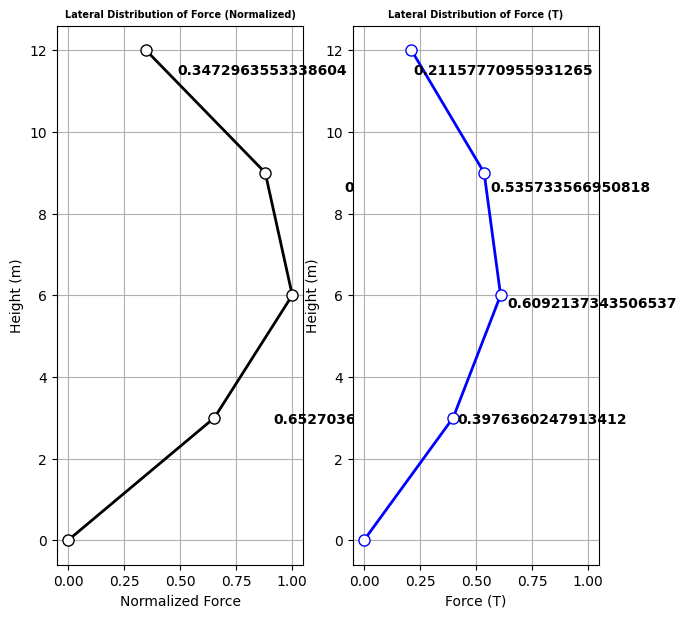

In [55]:
Hacum = np.zeros(gdl)
Hacum[0] = H[0]

for i in range(gdl):
    Hacum[i] = Hacum[i - 1] + H[i]

graf = np.zeros((gdl, 2))

for i in range(gdl):
    graf[i, 0] = F_n[i]
    graf[i, 1] = Hacum[i]

graf = np.vstack(([0, 0], graf))

escala = 7
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(escala,escala))

# First subplot
ax1.plot(graf[:, 0], graf[:, 1], '-ok', markersize=8, markerfacecolor='w', linewidth=2)
ax1.grid(True)
ax1.set_title('Lateral Distribution of Force (Normalized)', fontweight='bold', fontsize=escala)
ax1.set_xlabel('Normalized Force')
ax1.set_ylabel('Height (m)')

# Label text using str function
for i in range(len(graf) - 1):
    ax1.text(graf[i + 1, 0] * 1.4, graf[i + 1, 1] * 0.95, str(graf[i + 1, 0]), fontsize=10, fontweight='bold')


# Second subplot
ax2.plot(graf[:, 0] * F[-1,modo_vibracion], graf[:, 1], '-ob', markersize=8, markerfacecolor='w', linewidth=2)
ax2.grid(True)
ax2.set_title('Lateral Distribution of Force (T)', fontweight='bold', fontsize=escala)
ax2.set_xlabel('Force (T)')
ax2.set_ylabel('Height (m)')

for i in range(len(graf) - 1):
    ax2.text(graf[i + 1, 0] * F[-1,modo_vibracion] * 1.05, graf[i + 1, 1] * 0.95, str(graf[i + 1, 0] * F[-1,modo_vibracion]), fontsize=10, fontweight='bold')

plt.show()

In [56]:
c1 = 0.2
c2 = 0.3
num_columnas = 9
pisos = 3
altura_entrepiso = 3
print(f'vol_columnas20 es: {c1*c1*num_columnas*pisos*altura_entrepiso} m3')
print(f'vol_columnas30 es: {c2*c2*num_columnas*pisos*altura_entrepiso} m3')

vol_columnas20 es: 3.240000000000001 m3
vol_columnas30 es: 7.289999999999999 m3
